# Detrending, Stylized Facts and the Business Cycle

In an influential article, Harvey and Jaeger (1993) described the use of unobserved components models (also known as "structural time series models") to derive stylized facts of the business cycle.

Their paper begins:

    "Establishing the 'stylized facts' associated with a set of time series is widely considered a crucial step
    in macroeconomic research ... For such facts to be useful they should (1) be consistent with the stochastic
    properties of the data and (2) present meaningful information."
    
In particular, they make the argument that these goals are often better met using the unobserved components approach rather than the popular Hodrick-Prescott filter or Box-Jenkins ARIMA modeling techniques.

statsmodels has the ability to perform all three types of analysis, and below we follow the steps of their paper, using a slightly updated dataset.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from IPython.display import Latex, display

## Unobserved Components

The unobserved components model available in statsmodels can be written as:

$$
y_t = \underbrace{\mu_{t}}_{\text{trend}} + \underbrace{\gamma_{t}}_{\text{seasonal}} + \underbrace{c_{t}}_{\text{cycle}} + \sum_{j=1}^k \underbrace{\beta_j x_{jt}}_{\text{explanatory}} + \underbrace{\varepsilon_t}_{\text{irregular}}
$$

see Durbin and Koopman 2012, Chapter 3 for notation and additional details. Notice that different specifications for the different individual components can support a wide range of models. The specific models considered in the paper and below are specializations of this general equation.

### Trend

The trend component is a dynamic extension of a regression model that includes an intercept and linear time-trend.

$$
\begin{align}
\underbrace{\mu_{t+1}}_{\text{level}} & = \mu_t + \nu_t + \eta_{t+1} \qquad & \eta_{t+1} \sim N(0, \sigma_\eta^2) \\\\
\underbrace{\nu_{t+1}}_{\text{trend}} & = \nu_t + \zeta_{t+1} & \zeta_{t+1} \sim N(0, \sigma_\zeta^2) \\
\end{align}
$$

where the level is a generalization of the intercept term that can dynamically vary across time, and the trend is a generalization of the time-trend such that the slope can dynamically vary across time.

For both elements (level and trend), we can consider models in which:

- The element is included vs excluded (if the trend is included, there must also be a level included).
- The element is deterministic vs stochastic (i.e. whether or not the variance on the error term is confined to be zero or not)

The only additional parameters to be estimated via MLE are the variances of any included stochastic components.

This leads to the following specifications:

|                                                                      | Level | Trend | Stochastic Level | Stochastic Trend |
|----------------------------------------------------------------------|-------|-------|------------------|------------------|
| Constant                                                             | ✓     |       |                  |                  |
| Local Level <br /> (random walk)                                     | ✓     |       | ✓                |                  |
| Deterministic trend                                                  | ✓     | ✓     |                  |                  |
| Local level with deterministic trend <br /> (random walk with drift) | ✓     | ✓     | ✓                |                  |
| Local linear trend                                                   | ✓     | ✓     | ✓                | ✓                |
| Smooth trend <br /> (integrated random walk)                         | ✓     | ✓     |                  | ✓                |

### Seasonal

The seasonal component is written as:

<span>$$
\gamma_t = - \sum_{j=1}^{s-1} \gamma_{t+1-j} + \omega_t \qquad \omega_t \sim N(0, \sigma_\omega^2)
$$</span>

The periodicity (number of seasons) is `s`, and the defining character is that (without the error term), the seasonal components sum to zero across one complete cycle. The inclusion of an error term allows the seasonal effects to vary over time.

The variants of this model are:

- The periodicity `s`
- Whether or not to make the seasonal effects stochastic.

If the seasonal effect is stochastic, then there is one additional parameter to estimate via MLE (the variance of the error term).

### Cycle

The cyclical component is intended to capture cyclical effects at time frames much longer than captured by the seasonal component. For example, in economics the cyclical term is often intended to capture the business cycle, and is then expected to have a period between "1.5 and 12 years" (see Durbin and Koopman).

The cycle is written as:

<span>$$
\begin{align}
c_{t+1} & = c_t \cos \lambda_c + c_t^* \sin \lambda_c + \tilde \omega_t \qquad & \tilde \omega_t \sim N(0, \sigma_{\tilde \omega}^2) \\\\
c_{t+1}^* & = -c_t \sin \lambda_c + c_t^* \cos \lambda_c + \tilde \omega_t^* & \tilde \omega_t^* \sim N(0, \sigma_{\tilde \omega}^2)
\end{align}
$$</span>

The parameter $\lambda_c$ (the frequency of the cycle) is an additional parameter to be estimated by MLE. If the seasonal effect is stochastic, then there is one another parameter to estimate (the variance of the error term - note that both of the error terms here share the same variance, but are assumed to have independent draws).

### Irregular

The irregular component is assumed to be a white noise error term. Its variance is a parameter to be estimated by MLE; i.e.

$$
\varepsilon_t \sim N(0, \sigma_\varepsilon^2)
$$

In some cases, we may want to generalize the irregular component to allow for autoregressive effects:

$$
\varepsilon_t = \rho(L) \varepsilon_{t-1} + \epsilon_t, \qquad \epsilon_t \sim N(0, \sigma_\epsilon^2)
$$

In this case, the autoregressive parameters would also be estimated via MLE.

### Regression effects

We may want to allow for explanatory variables by including additional terms

<span>$$
\sum_{j=1}^k \beta_j x_{jt}
$$</span>

or for intervention effects by including

<span>$$
\begin{align}
\delta w_t \qquad \text{where} \qquad w_t & = 0, \qquad t < \tau, \\\\
& = 1, \qquad t \ge \tau
\end{align}
$$</span>

These additional parameters could be estimated via MLE or by including them as components of the state space formulation.


## Data

Following Harvey and Jaeger, we will consider the following time series:

- US real GNP, "output", ([GNPC96](https://research.stlouisfed.org/fred2/series/GNPC96))
- US GNP implicit price deflator, "prices", ([GNPDEF](https://research.stlouisfed.org/fred2/series/GNPDEF))
- US monetary base, "money", ([AMBSL](https://research.stlouisfed.org/fred2/series/AMBSL))

The time frame in the original paper varied across series, but was broadly 1954-1989. Below we use data from the period 1948-2008 for all series. Although the unobserved components approach allows isolating a seasonal component within the model, the series considered in the paper, and here, are already seasonally adjusted.

All data series considered here are taken from [Federal Reserve Economic Data (FRED)](https://research.stlouisfed.org/fred2/). Conveniently, the Python library [Pandas](https://pandas.pydata.org/) has the ability to download data from FRED directly.

In [2]:
# Datasets
from pandas_datareader.data import DataReader

# Get the raw data
start = "1948-01"
end = "2008-01"
us_gnp = DataReader("GNPC96", "fred", start=start, end=end)
us_gnp_deflator = DataReader("GNPDEF", "fred", start=start, end=end)
us_monetary_base = (
    DataReader("AMBSL", "fred", start=start, end=end).resample("QS").mean()
)
recessions = (
    DataReader("USRECQ", "fred", start=start, end=end)
    .resample("QS")
    .last()
    .values[:, 0]
)

# Construct the dataframe
dta = pd.concat(map(np.log, (us_gnp, us_gnp_deflator, us_monetary_base)), axis=1)
dta.columns = ["US GNP", "US Prices", "US monetary base"]
dta.index.freq = dta.index.inferred_freq
dates = dta.index._mpl_repr()

To get a sense of these three variables over the timeframe, we can plot them:

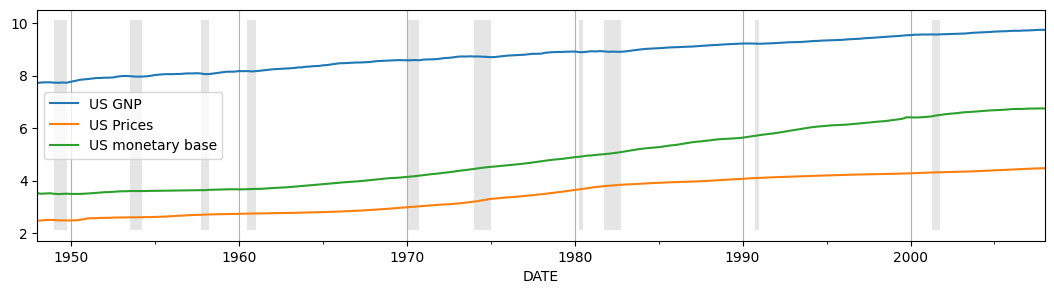

In [3]:
# Plot the data
ax = dta.plot(figsize=(13, 3))
ylim = ax.get_ylim()
ax.xaxis.grid()
ax.fill_between(
    dates, ylim[0] + 1e-5, ylim[1] - 1e-5, recessions, facecolor="k", alpha=0.1
);

## Model

Since the data is already seasonally adjusted and there are no obvious explanatory variables, the generic model considered is:

$$
y_t = \underbrace{\mu_{t}}_{\text{trend}} + \underbrace{c_{t}}_{\text{cycle}} + \underbrace{\varepsilon_t}_{\text{irregular}}
$$

The irregular will be assumed to be white noise, and the cycle will be stochastic and damped. The final modeling choice is the specification to use for the trend component. Harvey and Jaeger consider two models:

1. Local linear trend (the "unrestricted" model)
2. Smooth trend (the "restricted" model, since we are forcing $\sigma_\eta = 0$)

Below, we construct `kwargs` dictionaries for each of these model types. Notice that rather that there are two ways to specify the models. One way is to specify components directly, as in the table above. The other way is to use string names which map to various specifications.

In [4]:
# Model specifications

# Unrestricted model, using string specification
unrestricted_model = {
    "level": "local linear trend",
    "cycle": True,
    "damped_cycle": True,
    "stochastic_cycle": True,
}

# Unrestricted model, setting components directly
# This is an equivalent, but less convenient, way to specify a
# local linear trend model with a stochastic damped cycle:
# unrestricted_model = {
#     'irregular': True, 'level': True, 'stochastic_level': True, 'trend': True, 'stochastic_trend': True,
#     'cycle': True, 'damped_cycle': True, 'stochastic_cycle': True
# }

# The restricted model forces a smooth trend
restricted_model = {
    "level": "smooth trend",
    "cycle": True,
    "damped_cycle": True,
    "stochastic_cycle": True,
}

# Restricted model, setting components directly
# This is an equivalent, but less convenient, way to specify a
# smooth trend model with a stochastic damped cycle. Notice
# that the difference from the local linear trend model is that
# `stochastic_level=False` here.
# unrestricted_model = {
#     'irregular': True, 'level': True, 'stochastic_level': False, 'trend': True, 'stochastic_trend': True,
#     'cycle': True, 'damped_cycle': True, 'stochastic_cycle': True
# }

We now fit the following models:

1. Output, unrestricted model
2. Prices, unrestricted model
3. Prices, restricted model
4. Money, unrestricted model
5. Money, restricted model

In [5]:
# Output
output_mod = sm.tsa.UnobservedComponents(dta["US GNP"], **unrestricted_model)
output_res = output_mod.fit(method="powell", disp=False)

# Prices
prices_mod = sm.tsa.UnobservedComponents(dta["US Prices"], **unrestricted_model)
prices_res = prices_mod.fit(method="powell", disp=False)

prices_restricted_mod = sm.tsa.UnobservedComponents(
    dta["US Prices"], **restricted_model
)
prices_restricted_res = prices_restricted_mod.fit(method="powell", disp=False)

# Money
money_mod = sm.tsa.UnobservedComponents(dta["US monetary base"], **unrestricted_model)
money_res = money_mod.fit(method="powell", disp=False)

money_restricted_mod = sm.tsa.UnobservedComponents(
    dta["US monetary base"], **restricted_model
)
money_restricted_res = money_restricted_mod.fit(method="powell", disp=False)

Once we have fit these models, there are a variety of ways to display the information. Looking at the model of US GNP, we can summarize the fit of the model using the `summary` method on the fit object.

In [6]:
print(output_res.summary())

                            Unobserved Components Results                            
Dep. Variable:                        US GNP   No. Observations:                  241
Model:                    local linear trend   Log Likelihood                 769.972
                   + damped stochastic cycle   AIC                          -1527.945
Date:                       Mon, 12 Jan 2026   BIC                          -1507.136
Time:                               18:45:18   HQIC                         -1519.558
Sample:                           01-01-1948                                         
                                - 01-01-2008                                         
Covariance Type:                         opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
sigma2.irregular    1.4e-06   7.35e-06      0.191      0

For unobserved components models, and in particular when exploring stylized facts in line with point (2) from the introduction, it is often more instructive to plot the estimated unobserved components (e.g. the level, trend, and cycle) themselves to see if they provide a meaningful description of the data.

The `plot_components` method of the fit object can be used to show plots and confidence intervals of each of the estimated states, as well as a plot of the observed data versus the one-step-ahead predictions of the model to assess fit.

/opt/hostedtoolcache/Python/3.10.19/x64/lib/python3.10/site-packages/statsmodels/tsa/statespace/structural.py:1821: RuntimeWarning: invalid value encountered in sqrt
  std_errors = np.sqrt(component_bunch["%s_cov" % which])


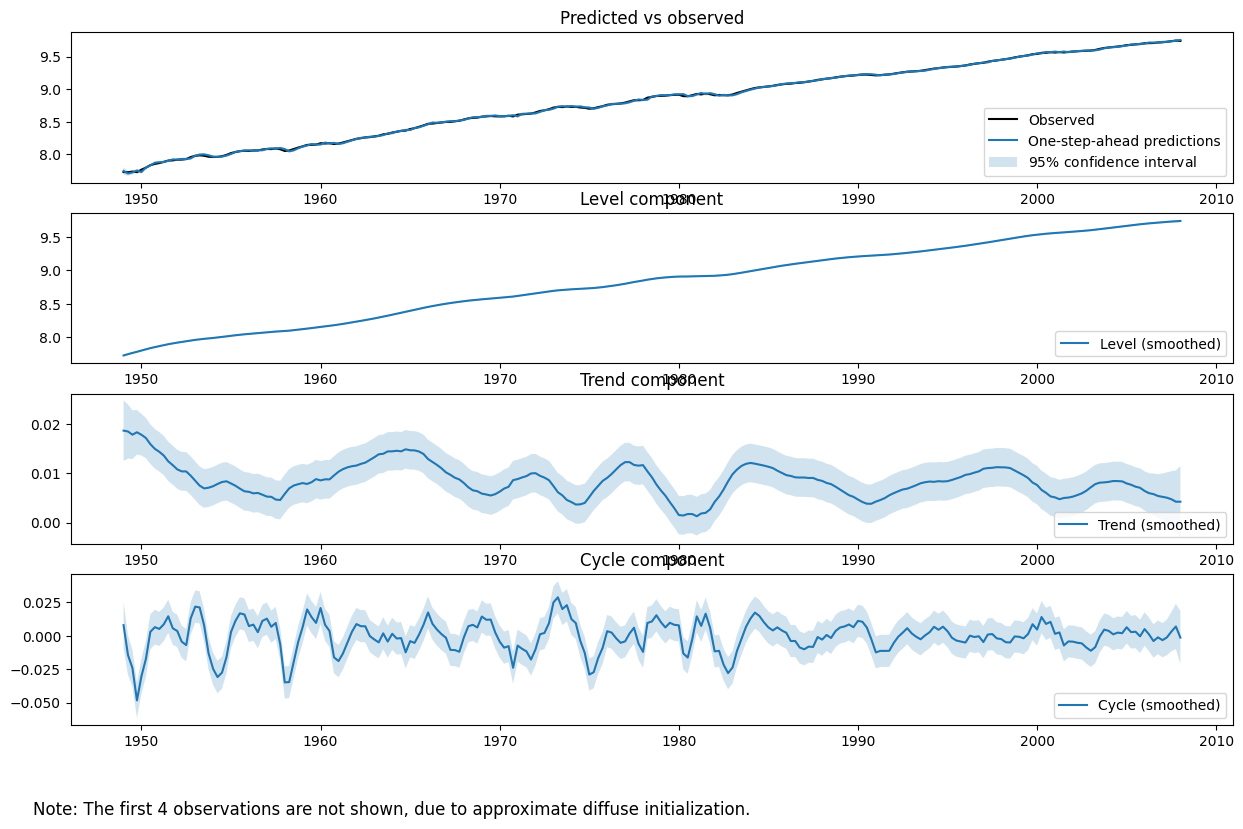

In [7]:
fig = output_res.plot_components(legend_loc="lower right", figsize=(15, 9));

Finally, Harvey and Jaeger summarize the models in another way to highlight the relative importances of the trend and cyclical components; below we replicate their Table I. The values we find are broadly consistent with, but different in the particulars from, the values from their table.

In [8]:
# Create Table I
table_i = np.zeros((5, 6))

start = dta.index[0]
end = dta.index[-1]
time_range = "%d:%d-%d:%d" % (start.year, start.quarter, end.year, end.quarter)
models = [
    ("US GNP", time_range, "None"),
    ("US Prices", time_range, "None"),
    ("US Prices", time_range, r"$\sigma_\eta^2 = 0$"),
    ("US monetary base", time_range, "None"),
    ("US monetary base", time_range, r"$\sigma_\eta^2 = 0$"),
]
index = pd.MultiIndex.from_tuples(
    models, names=["Series", "Time range", "Restrictions"]
)
parameter_symbols = [
    r"$\sigma_\zeta^2$",
    r"$\sigma_\eta^2$",
    r"$\sigma_\kappa^2$",
    r"$\rho$",
    r"$2 \pi / \lambda_c$",
    r"$\sigma_\varepsilon^2$",
]

i = 0
for res in (
    output_res,
    prices_res,
    prices_restricted_res,
    money_res,
    money_restricted_res,
):
    if res.model.stochastic_level:
        (
            sigma_irregular,
            sigma_level,
            sigma_trend,
            sigma_cycle,
            frequency_cycle,
            damping_cycle,
        ) = res.params
    else:
        (sigma_irregular, sigma_level, sigma_cycle, frequency_cycle, damping_cycle) = (
            res.params
        )
        sigma_trend = np.nan
    period_cycle = 2 * np.pi / frequency_cycle

    table_i[i, :] = [
        sigma_level * 1e7,
        sigma_trend * 1e7,
        sigma_cycle * 1e7,
        damping_cycle,
        period_cycle,
        sigma_irregular * 1e7,
    ]
    i += 1

pd.set_option(
    "float_format", lambda x: "%.4g" % np.round(x, 2) if not np.isnan(x) else "-"
)
table_i = pd.DataFrame(table_i, index=index, columns=parameter_symbols)
table_i

$\sigma_\zeta^2$  \
Series           Time range    Restrictions                            
US GNP           1948:1-2008:1 None                            27.76   
US Prices        1948:1-2008:1 None                                0   
                               $\sigma_\eta^2 = 0$             61.91   
US monetary base 1948:1-2008:1 None                            63.75   
                               $\sigma_\eta^2 = 0$             18.96   

                                                    $\sigma_\eta^2$  \
Series           Time range    Restrictions                           
US GNP           1948:1-2008:1 None                           31.99   
US Prices        1948:1-2008:1 None                           61.89   
                               $\sigma_\eta^2 = 0$              NaN   
US monetary base 1948:1-2008:1 None                           18.94   
                               $\sigma_\eta^2 = 0$              NaN   

                                                    $\sigma_\kappa^2$  $\rho$  \
Series           Time range    Restrictions                                     
US GNP           1948:1-2008:1 None                             387.1    0.87   
US Prices        1948:1-2008:1 None                              20.7    0.43   
                               $\sigma_\eta^2 = 0$              20.71    0.43   
US monetary base 1948:1-2008:1 None                             196.3    0.89   
                               $\sigma_\eta^2 = 0$              246.9    0.89   

                                                    $2 \pi / \lambda_c$  \
Series           Time range    Restrictions                               
US GNP           1948:1-2008:1 None                               13.98   
US Prices        1948:1-2008:1 None                                6.55   
                               $\sigma_\eta^2 = 0$                 6.56   
US monetary base 1948:1-2008:1 None                               23.17   
                               $\sigma_\eta^2 = 0$                23.77   

                                                    $\sigma_\varepsilon^2$  
Series           Time range    Restrictions                                 
US GNP           1948:1-2008:1 None                                     14  
US Prices        1948:1-2008:1 None                                      0  
                               $\sigma_\eta^2 = 0$                       0  
US monetary base 1948:1-2008:1 None                                      0  
                               $\sigma_\eta^2 = 0$                       0